In [7]:
import pandas as pd
import numpy as np

# Read CSV files
times_df = pd.read_csv("morrisonhighresquarriesdates.csv").drop_duplicates()
edges_df = pd.read_csv("morrisonhighresedges.csv")
times_df = times_df.reset_index(drop=True)
times_df.columns = ['from', 'time_foster', 'time_turner', 'time_maidment']
times_df

,from,time_foster,time_turner,time_maidment
0,Bone Cabin Quarry,Zone 2,2,6
1,Cleveland-Lloyd Quarry,Zone 5,3,4
2,Cope's Nipple,Zone 6,4,5
3,Dinosaur National Monument Quarry,Zone 5,3,4
4,Dry Mesa Quarry,Zone 4,2,4
5,FPA General,Zone 4,na,4
6,Hanksville-Burpee Quarry,Zone 4,2,4
7,Howe Quarry,Zone 2,2,5
8,Howe-Stephens Quarry,Zone 2,na,5
9,Little Houston Quarry,Zone 2,2,6


In [8]:
edges_df

,from,to,weight
0,Bone Cabin Quarry,class 10non-selective grazergraviportal,1
1,Bone Cabin Quarry,class 11non-selective browserGraviportal,1
2,Bone Cabin Quarry,class 11non-selective grazergraviportal,1
3,Bone Cabin Quarry,class 11non-selective mixed feedergraviportal,2
4,Bone Cabin Quarry,class 13non-selective grazerGraviportal,1
...,...,...,...
150,Stovall Quarry 1,class 11non-selective browserGraviportal,1
151,Stovall Quarry 1,class 13non-selective grazerGraviportal,1
152,Stovall Quarry 1,class 15non-selective browsergraviportal,1
153,Stovall Quarry 1,class 7non-selective mixed feedersub-cursorial,1


In [9]:
edges_df = edges_df.merge(times_df, on='from', how='left')
edges_df

,from,to,weight,time_foster,time_turner,time_maidment
0,Bone Cabin Quarry,class 10non-selective grazergraviportal,1,Zone 2,2,6
1,Bone Cabin Quarry,class 11non-selective browserGraviportal,1,Zone 2,2,6
2,Bone Cabin Quarry,class 11non-selective grazergraviportal,1,Zone 2,2,6
3,Bone Cabin Quarry,class 11non-selective mixed feedergraviportal,2,Zone 2,2,6
4,Bone Cabin Quarry,class 13non-selective grazerGraviportal,1,Zone 2,2,6
...,...,...,...,...,...,...
150,Stovall Quarry 1,class 11non-selective browserGraviportal,1,Zone 5,3,5
151,Stovall Quarry 1,class 13non-selective grazerGraviportal,1,Zone 5,3,5
152,Stovall Quarry 1,class 15non-selective browsergraviportal,1,Zone 5,3,5
153,Stovall Quarry 1,class 7non-selective mixed feedersub-cursorial,1,Zone 5,3,5


In [10]:
edges_df['time_foster'] = edges_df['time_foster'].str.extract('(\d+)').astype(int)
edges_df

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ty/5bvjyd1n4dx2ymnhbn1s9579brngf7/T/ipykernel_26955/3176716115.py:1: SyntaxWarning: invalid escape sequence '\d'
  edges_df['time_foster'] = edges_df['time_foster'].str.extract('(\d+)').astype(int)


,from,to,weight,time_foster,time_turner,time_maidment
0,Bone Cabin Quarry,class 10non-selective grazergraviportal,1,2,2,6
1,Bone Cabin Quarry,class 11non-selective browserGraviportal,1,2,2,6
2,Bone Cabin Quarry,class 11non-selective grazergraviportal,1,2,2,6
3,Bone Cabin Quarry,class 11non-selective mixed feedergraviportal,2,2,2,6
4,Bone Cabin Quarry,class 13non-selective grazerGraviportal,1,2,2,6
...,...,...,...,...,...,...
150,Stovall Quarry 1,class 11non-selective browserGraviportal,1,5,3,5
151,Stovall Quarry 1,class 13non-selective grazerGraviportal,1,5,3,5
152,Stovall Quarry 1,class 15non-selective browsergraviportal,1,5,3,5
153,Stovall Quarry 1,class 7non-selective mixed feedersub-cursorial,1,5,3,5


In [11]:
edges_df.to_csv("morrisonhighresedges_new.csv", index=False)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from infomap import Infomap
import networkx as nx
import numpy as np

# load csv
csv_path = "morrisonhighresedges_new.csv" 
df = pd.read_csv(csv_path)

# map node names to int
unique_nodes = pd.unique(df[['from', 'to']].values.ravel())
node_map = {name: i for i, name in enumerate(unique_nodes)}
reverse_node_map = {i: name for name, i in node_map.items()}

# build network with infomap
im = Infomap("--two-level --markov-time 0.6 --preferred-number-of-modules 5 --num-trials 150")

for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    weight = float(row["weight"])
    im.add_link(u, v, weight)

im.run()

# id modules
modules = {node.node_id: node.module_id for node in im.nodes}
name_modules = {reverse_node_map[node_id]: mod for node_id, mod in modules.items()}


  Infomap v2.8.0 starts at 2025-05-24 17:29:32
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    markov-time = 0.6
                    preferred-number-of-modules = 5
                    num-trials = 150
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 45 nodes and 155 links...
  -> Rescale link flow with global Markov time 0.6
  -> One-level codelength: 5.12774584

Trial 1/150 starting at 2025-05-24 17:29:32
Two-level compression: 5.6% 0.61% 0.37220234% 0.0404172705% 0.291079256% 
Partitioned to codelength 0.802726753 + 3.97263039 + 0 = 4.775357142 in 5 modules.

=> Trial 1/150 finished in 0.000428167s with codelength 4.77535714

Trial 2/150 starting at 2025-05-24 17:29:32
Two-level compression: 5.9% 1.2% 0.0168389363% 
Partitioned to codelength 0.796

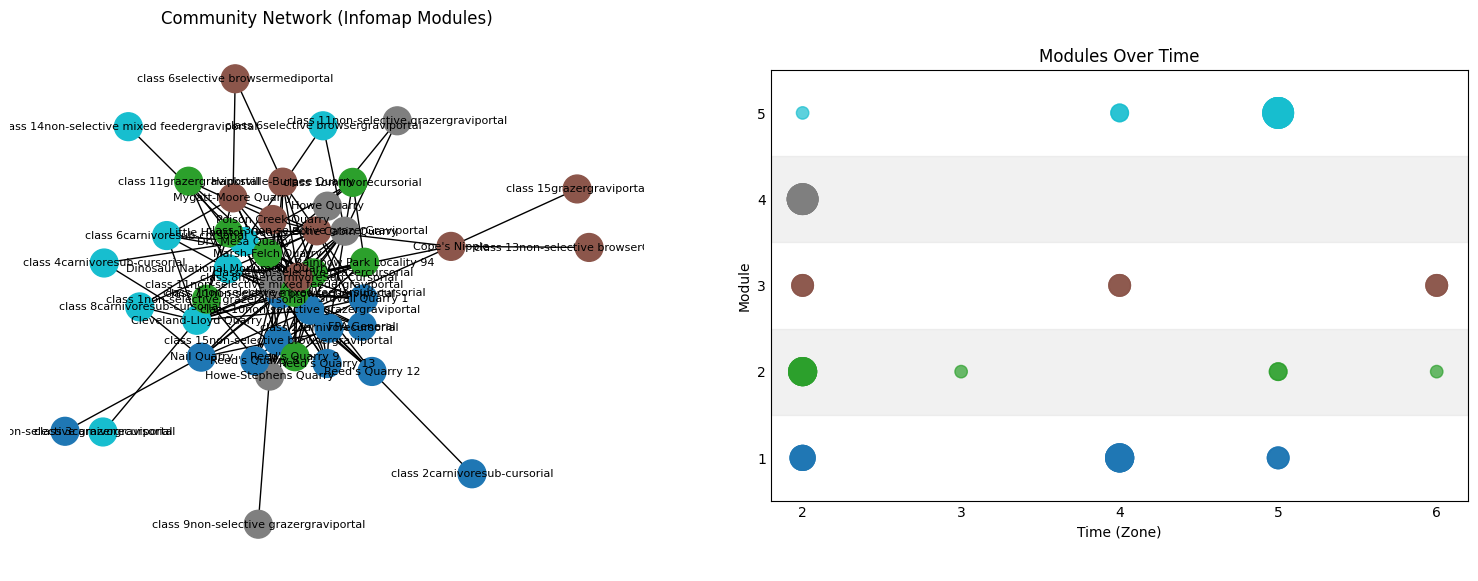

In [9]:

# plot network and stepped scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# network plot
pos = nx.spring_layout(G, seed=42)
node_colors = [modules[n] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=400, with_labels=False, ax=ax1)
nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes}, font_size=8, ax=ax1)
ax1.set_title("Community Network (Infomap Modules)")

# stepped plot

# Calculate the number of nodes for each (zone, module) pair
size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')

# Merge this data back into the plot dataframe
plot_df = plot_df.merge(size_data, on=["zone", "module"])

# make the plot
module_ids = sorted(plot_df["module"].unique())
for module_id in module_ids:
    if module_id % 2 == 0:
        ax2.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

scatter = ax2.scatter(
    plot_df["zone"], plot_df["module"],
    s=plot_df["node_count"] * 80,  
    c=plot_df["module"], cmap="tab10", alpha=0.7
)

ax2.set_xlabel("Time (Zone)")
ax2.set_ylabel("Module")
ax2.set_title("Modules Over Time")

# Set x-ticks and labels
ax2.set_xticks(list(zone_map.values()))
ax2.set_xticklabels(list(zone_map.keys()))

# Set y-ticks at integer module IDs
ax2.set_yticks(module_ids)

# remove tick marks keep labels
ax2.tick_params(axis='both', which='both', length=0)

# set ylim
ax2.set_ylim(min(module_ids) - 0.5, max(module_ids) + 0.5)

# Remove gridlines
ax2.grid(False)

# Adjust plot layout
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + 0.1, box.width * 1.1, box.height * 0.8])

plt.show()

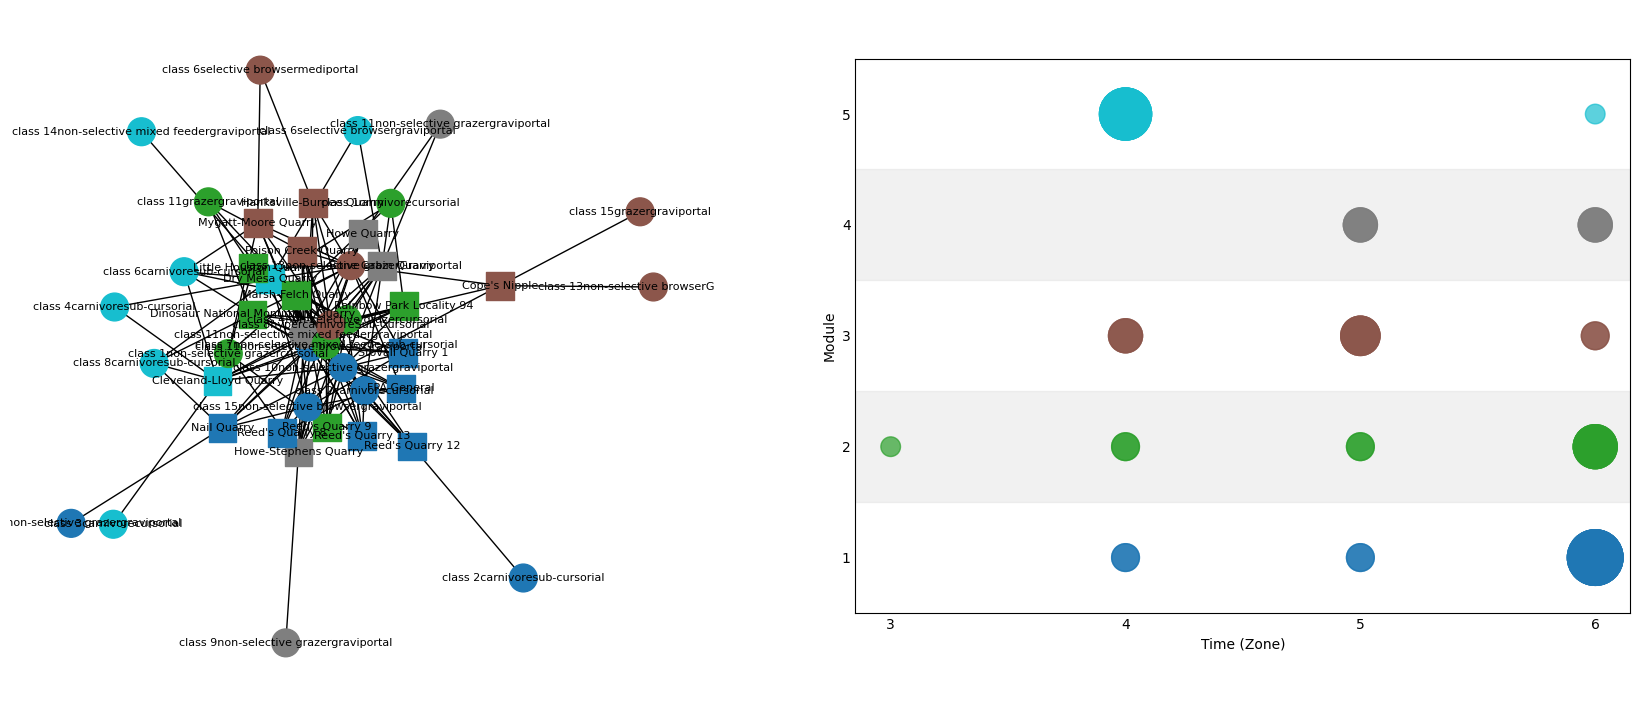

In [11]:
time_col= "time_maidment" # one of: 'foster', 'turner', 'maidment'

# sort data for plotting
zone_order = sorted(df[time_col].unique())
zone_map = {zone: i + 1 for i, zone in enumerate(zone_order)}

node_modules = []
for name in unique_nodes:
    time = df[df['from'] == name][time_col].values
    if len(time) == 0:
        time = df[df['to'] == name][time_col].values
    time = time[0] if len(time) > 0 else "Zone 0"
    module = name_modules[name]
    node_modules.append((name, module, zone_map.get(time, 0)))

plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])

# make networkx graph
G = nx.Graph()
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    G.add_edge(u, v, weight=row["weight"])

# Assign module as a node attribute
nx.set_node_attributes(G, modules, "module")

# plot network and stepped scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

# Network plot
# Assign shapes 
node_shapes = {}
for _, row in df.iterrows():
    node_shapes[node_map[row["to"]]] = "circle" 
    node_shapes[node_map[row["from"]]] = "square"  

# Group nodes by shape
square_nodes = [n for n, shape in node_shapes.items() if shape == "square"]
circle_nodes = [n for n, shape in node_shapes.items() if shape == "circle"]

# Node positions
pos = nx.spring_layout(G, seed=42)

# Draw edges
nx.draw_networkx_edges(G, pos, ax=ax1)

# Draw square nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=square_nodes,
    node_shape='s',
    node_color=[modules[n] for n in square_nodes],
    cmap=plt.cm.tab10,
    node_size=400,
    ax=ax1
)

# Draw circle nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=circle_nodes,
    node_shape='o',
    node_color=[modules[n] for n in circle_nodes],
    cmap=plt.cm.tab10,
    node_size=400,
    ax=ax1
)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes}, font_size=8, ax=ax1)

# Stepped scatter plot

# Calculate the number of nodes for each (zone, module) pair
size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')
plot_df = plot_df.merge(size_data, on=["zone", "module"])

# Background shading for modules
module_ids = sorted(plot_df["module"].unique())
for module_id in module_ids:
    if module_id % 2 == 0:
        ax2.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

# Plot scatter with size reflecting node count
scatter = ax2.scatter(
    plot_df["zone"], plot_df["module"],
    s=plot_df["node_count"] * 200,
    c=plot_df["module"], cmap="tab10", alpha=0.7
)

# Axis labels and title
ax2.set_xlabel("Time (Zone)")
ax2.set_ylabel("Module")

# X/Y ticks and labels
ax2.set_xticks(list(zone_map.values()))
ax2.set_xticklabels(list(zone_map.keys()))
ax2.set_yticks(module_ids)

# Clean up axes
ax2.tick_params(axis='both', which='both', length=0)
ax2.set_ylim(min(module_ids) - 0.5, max(module_ids) + 0.5)
ax2.grid(False)

# Remove the black border from the network graph
for spine in ax1.spines.values():
    spine.set_visible(False)

# Layout adjustment
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + 0.1, box.width * 1.1, box.height * 0.8])
plt.show()


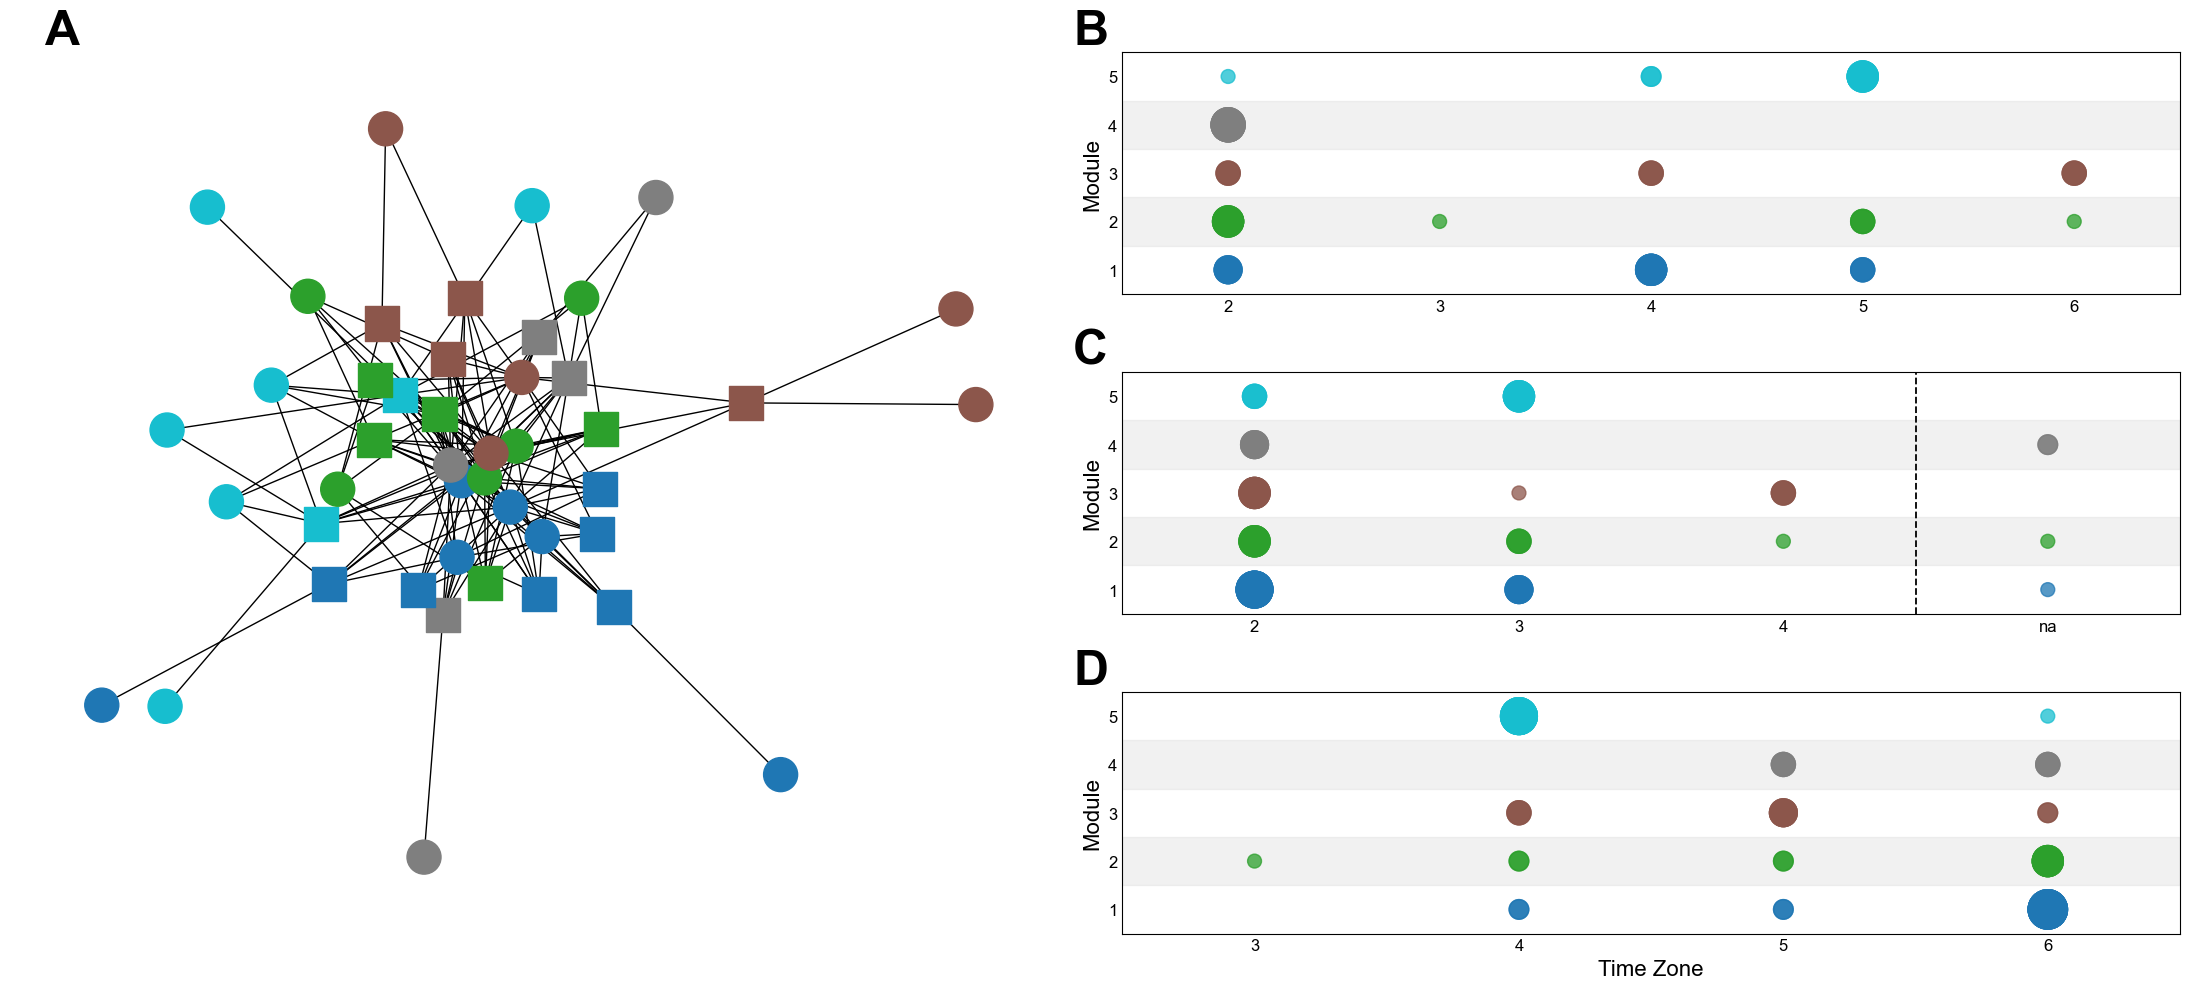

In [2]:
time_cols = ["time_foster", "time_turner", "time_maidment"]
plt.rcParams['font.family'] = 'Arial'
# Build zone_maps for all time schemes
zone_maps = {
    time_col: {zone: i + 1 for i, zone in enumerate(sorted(df[time_col].dropna().unique()))}
    for time_col in time_cols
}

# Make networkx graph
G = nx.Graph()
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    G.add_edge(u, v, weight=row["weight"])

nx.set_node_attributes(G, modules, "module")

# Prepare for plotting: 1 network plot + 3 stepped plots
fig = plt.figure(figsize=(22, 10))
gs = fig.add_gridspec(3, 2, width_ratios=[2, 2])
ax_net = fig.add_subplot(gs[:, 0])  # Network plot on the left
axes = [fig.add_subplot(gs[i, 1]) for i in range(3)]  # 3 vertical plots on the right

# ======= Network Plot =======
# Assign shapes 
node_shapes = {}
for _, row in df.iterrows():
    node_shapes[node_map[row["to"]]] = "circle"
    node_shapes[node_map[row["from"]]] = "square"

# Group nodes by shape
square_nodes = [n for n, shape in node_shapes.items() if shape == "square"]
circle_nodes = [n for n, shape in node_shapes.items() if shape == "circle"]

# Node positions
pos = nx.spring_layout(G, seed=42)

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, ax=ax_net)
nx.draw_networkx_nodes(G, pos, nodelist=square_nodes, node_shape='s',
                       node_color=[modules[n] for n in square_nodes],
                       cmap=plt.cm.tab10, node_size=600, ax=ax_net)
nx.draw_networkx_nodes(G, pos, nodelist=circle_nodes, node_shape='o',
                       node_color=[modules[n] for n in circle_nodes],
                       cmap=plt.cm.tab10, node_size=600, ax=ax_net)

#nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes},
                        #font_size=8, ax=ax_net)

for spine in ax_net.spines.values():
    spine.set_visible(False)
ax_net.set_title("A", y=1, x=0.05, fontsize=35, fontweight='bold')

letter_dict = {1: "B", 2: "C", 3: "D"}

# stepped scatter plots
for i, time_col in enumerate(time_cols):
    ax = axes[i]
    zone_map = zone_maps[time_col]

    node_modules = []
    for name in unique_nodes:
        time = df[df['from'] == name][time_col].values
        if len(time) == 0:
            time = df[df['to'] == name][time_col].values
        time = time[0] if len(time) > 0 else "Zone 0"
        module = name_modules.get(name, -1)
        node_modules.append((name, module, zone_map.get(time, 0)))

    plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])

    # Calculate node count per (zone, module)
    size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')
    plot_df = plot_df.merge(size_data, on=["zone", "module"])

    module_ids = sorted(plot_df["module"].unique())
    for module_id in module_ids:
        if module_id % 2 == 0:
            ax.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

    # Plot scatter with size reflecting node count
    scatter = ax.scatter(
        plot_df["zone"], plot_df["module"],
        s=plot_df["node_count"] * 100,
        c=plot_df["module"], cmap="tab10", alpha=0.75
    )

    # Draw vertical line before 'na' for turner
    if time_col == "time_turner":
        for key, val in zone_map.items():
            if str(key).lower() == "na":
                ax.axvline(x=val - 0.5, color="black", linestyle="--", linewidth=1.3)
                break


    ax.set_ylabel("Module", fontsize=16)
    ax.set_title(letter_dict[i + 1], y=1, x=-0.03, fontsize=35, fontweight='bold')
    ax.set_xticks(list(zone_map.values()))
    ax.set_xticklabels(list(zone_map.keys()), fontsize=12)
    ax.set_yticks(module_ids)
    ax.set_yticklabels(module_ids, fontsize=12)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_ylim(min(module_ids) - 0.5, max(module_ids) + 0.5)
    ax.grid(False)
    # Only show x-axis label and ticks on the bottom plot
    if i == 2:  # Bottom subplot
        ax.set_xlabel("Time Zone", fontsize=16)
        ax.set_xticks(list(zone_map.values()))
        ax.set_xticklabels(list(zone_map.keys()), fontsize=12)
    else:  # Top and middle subplots
        ax.set_xlabel("")  # No x-label

    zones = list(zone_map.values())
    buffer = 0.5  # Adjust as needed (e.g. 1 for bigger gaps)
    ax.set_xlim(min(zones) - buffer, max(zones) + buffer)
    
plt.tight_layout()
plt.show()
# Save the final plot
fig.savefig("morrison_final_fig.png", dpi=600, bbox_inches='tight')

In [3]:
time_col= "time_maidment" # one of: 'foster', 'turner', 'maidment'

# sort data for plotting
zone_order = sorted(df[time_col].unique())
zone_map = {zone: i + 1 for i, zone in enumerate(zone_order)}

node_modules = []
for name in unique_nodes:
    time = df[df['from'] == name][time_col].values
    if len(time) == 0:
        time = df[df['to'] == name][time_col].values
    time = time[0] if len(time) > 0 else "Zone 0"
    module = name_modules[name]
    node_modules.append((name, module, zone_map.get(time, 0)))

plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])
plot_df = plot_df.drop(columns=["zone"]).sort_values(by="module").reset_index(drop=True)
plot_df.to_csv("morrison_modules.csv", index=False)

#### Alternative size calssification test

In [ ]:
df2 = df

# load csv
csv_path = "drymesahighsize.csv" 
df = pd.read_csv(csv_path)

zone_dict = dict(zip(df2['from'], df2['time']))
# add column to df called time which uses the zone_dict to map the from column to the time column
df['time'] = df['from'].map(zone_dict)
# make unmapped values Zone 0
df['time'] = df['time'].fillna('Zone 0')
df.to_csv("drymesahighsize.csv", index=False)

KeyError: 'time'

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from infomap import Infomap
import networkx as nx
import numpy as np

# load csv
csv_path = "drymesahighsize.csv" 
df = pd.read_csv(csv_path)

# map node names to int
unique_nodes = pd.unique(df[['from', 'to']].values.ravel())
node_map = {name: i for i, name in enumerate(unique_nodes)}
reverse_node_map = {i: name for name, i in node_map.items()}

# build network with infomap
im = Infomap("--two-level --markov-time 0.3 --preferred-number-of-modules 5")

for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    weight = float(row["weight"])
    im.add_link(u, v, weight)

im.run()

# id modules
modules = {node.node_id: node.module_id for node in im.nodes}
name_modules = {reverse_node_map[node_id]: mod for node_id, mod in modules.items()}

# sort data for plotting
zone_order = sorted(df['time'].unique())
zone_map = {zone: i + 1 for i, zone in enumerate(zone_order)}

node_modules = []
for name in unique_nodes:
    time = df[df['from'] == name]['time'].values
    if len(time) == 0:
        time = df[df['to'] == name]['time'].values
    time = time[0] if len(time) > 0 else "Zone 0"
    module = name_modules[name]
    node_modules.append((name, module, zone_map.get(time, 0)))

plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])

# make networkx graph
G = nx.Graph()
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    G.add_edge(u, v, weight=row["weight"])

# Assign module as a node attribute
nx.set_node_attributes(G, modules, "module")

  Infomap v2.8.0 starts at 2025-04-28 10:52:58
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    markov-time = 0.3
                    preferred-number-of-modules = 5
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 51 nodes and 151 links...
  -> Rescale link flow with global Markov time 0.3
  -> One-level codelength: 5.1655356

Trial 1/1 starting at 2025-04-28 10:52:58
Two-level compression: -1.8% 24% 
Partitioned to codelength 0.404374636 + 3.56544151 + 0 = 3.969816142 in 5 modules.

=> Trial 1/1 finished in 0.000305708s with codelength 3.96981614


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,          51] (sum: 

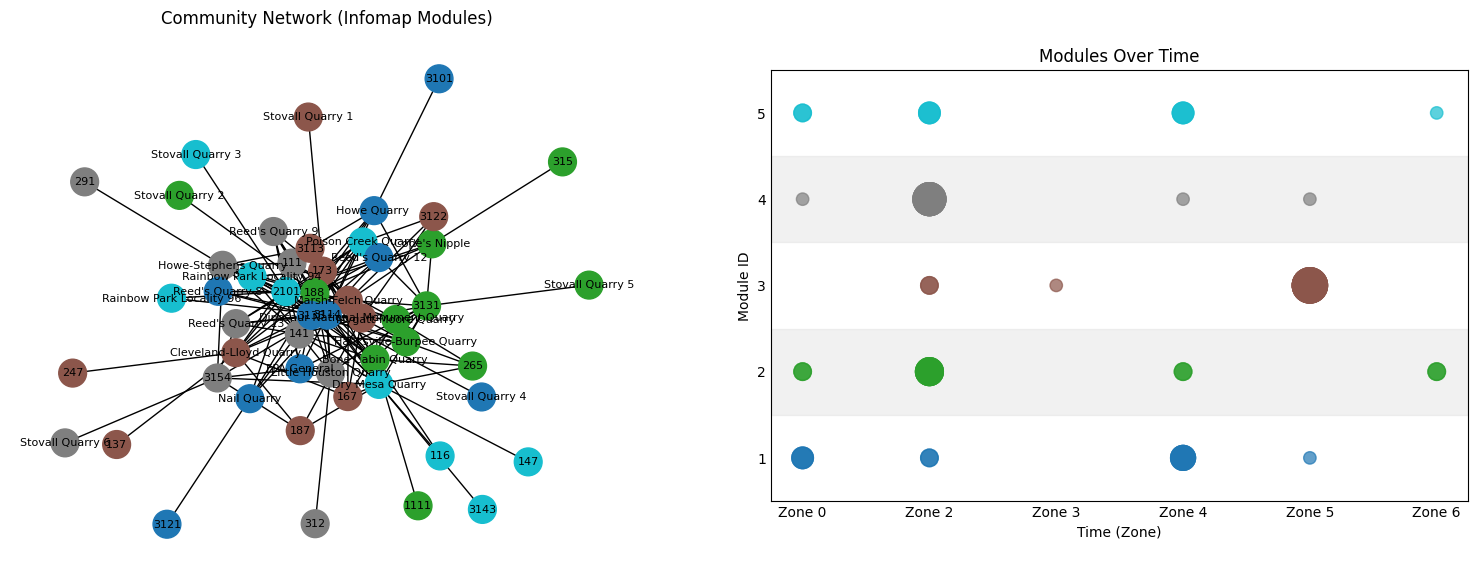

In [ ]:

# plot network and stepped scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# network plot
pos = nx.spring_layout(G, seed=42)
node_colors = [modules[n] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=400, with_labels=False, ax=ax1)
nx.draw_networkx_labels(G, pos, labels={node_map[name]: name for name in unique_nodes}, font_size=8, ax=ax1)
ax1.set_title("Community Network (Infomap Modules)")

# stepped plot

# Calculate the number of nodes for each (zone, module) pair
size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')

# Merge this data back into the plot dataframe
plot_df = plot_df.merge(size_data, on=["zone", "module"])

# make the plot
mmodule_ids = sorted(plot_df["module"].unique())
for module_id in module_ids:
    if module_id % 2 == 0:
        ax2.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

scatter = ax2.scatter(
    plot_df["zone"], plot_df["module"],
    s=plot_df["node_count"] * 80,  
    c=plot_df["module"], cmap="tab10", alpha=0.7
)

ax2.set_xlabel("Time (Zone)")
ax2.set_ylabel("Module")
ax2.set_title("Modules Over Time")

# Set x-ticks and labels
ax2.set_xticks(list(zone_map.values()))
ax2.set_xticklabels(list(zone_map.keys()))

# Set y-ticks at integer module IDs
ax2.set_yticks(mmodule_ids)

# remove tick marks keep labels
ax2.tick_params(axis='both', which='both', length=0)

# set ylim
ax2.set_ylim(min(mmodule_ids) - 0.5, max(mmodule_ids) + 0.5)

# Remove gridlines
ax2.grid(False)

# Adjust plot layout
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + 0.1, box.width * 1.1, box.height * 0.8])

plt.show()